In [1]:
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
from torchvision import datasets, transforms
import imgaug.augmenters as iaa

##  Load Data and Train MLP



In [2]:
model_urls = {
    'mnist': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth'
}

class MLP(nn.Module):
    def __init__(self, input_dims, n_hiddens, n_class):
        super(MLP, self).__init__()
        assert isinstance(input_dims, int), 'Please provide int for input_dims'
        self.input_dims = input_dims
        current_dims = input_dims
        layers = OrderedDict()

        if isinstance(n_hiddens, int):
            n_hiddens = [n_hiddens]
        else:
            n_hiddens = list(n_hiddens)
        for i, n_hidden in enumerate(n_hiddens):
            layers['fc{}'.format(i+1)] = nn.Linear(current_dims, n_hidden)
            layers['relu{}'.format(i+1)] = nn.ReLU()
            layers['drop{}'.format(i+1)] = nn.Dropout(0.2)
            current_dims = n_hidden
        layers['out'] = nn.Linear(current_dims, n_class)

        self.model= nn.Sequential(layers)
        print(self.model)

    def forward(self, input):
        input = input.view(input.size(0), -1)
        assert input.size(1) == self.input_dims
        return self.model.forward(input)

def mnist(input_dims=784, n_hiddens=[256, 256], n_class=10, pretrained=None):
    model = MLP(input_dims, n_hiddens, n_class)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['mnist'],map_location=torch.device('cpu'))
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

In [3]:
batch_size=1000
torch.manual_seed(5)

data_root = os.path.expanduser(os.path.join('/tmp/public_dataset/pytorch', 'mnist-data'))
train_data = datasets.MNIST(root=data_root, train=True, download=True,
                            transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
X_train, y_train = next(iter(train_loader))

test_data = datasets.MNIST(root=data_root, train=False, download=True,
                   transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
                                                                              
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2*batch_size, shuffle=True)
X_test, y_test = next(iter(test_loader))

In [4]:
m = mnist(pretrained=True).eval()

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
remove_classes = [0,1,2]
mask = torch.ones(len(y_test), dtype=bool)
for idx in remove_classes:
    mask = torch.logical_and(mask, y_test!=idx)

In [6]:
X_test = X_test[mask][:1000]
y_test = y_test[mask][:1000]

In [7]:
y_test.unique()

tensor([3, 4, 5, 6, 7, 8, 9])

In [8]:
def compute_accuracy(net, X, y):
    pred_logits = net(X)
    _, pred_y = torch.max(pred_logits, 1)
    acc = (pred_y == y).sum().item() / y.size(0)
    return acc

print('Training accuracy:', compute_accuracy(m, X_train, y_train))
print('Testing accuracy:', compute_accuracy(m, X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.99


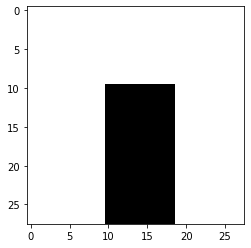

In [9]:
##  Dropout data
aug = iaa.CoarseDropout(0.3, size_percent=0.1)
mask = np.ones(X_train[0].numpy().shape, dtype=np.float32)
mask = aug(images=mask)
plt.imshow(mask[0],  cmap='gray')

In [10]:
mask[0, :, 18:] = 1
mask[0, 18:] = 1

Accuracy of augmented test data: 0.704


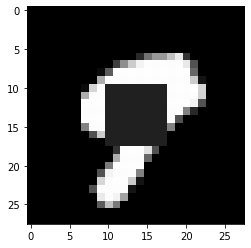

In [11]:
X_test_aug = torch.Tensor(X_test * mask)
features_test_aug = m(X_test_aug).detach().numpy()
print('Accuracy of augmented test data:', compute_accuracy(m, X_test_aug, y_test))
plt.imshow(X_test_aug[4].squeeze(),  cmap='gray')

ogvalue = compute_accuracy(m, X_test_aug, y_test)

In [12]:
# get features
features_train = m(X_train).detach().numpy()
features_test = m(X_test).detach().numpy()

## LOT
Source = features_test_aug\
Train --> MLP --> logits (10d)\
Target = features_test\
Test --> Aug(dropout) --> MLP --> logits (10d)


In [13]:
from lOT import LOT, solve_ot
from fc import FC
import time

In [14]:
start_time = time.time()
cluster_numx = 7
cluster_num = 20
eps = 80
lot = LOT(n_cluster_source= cluster_numx, n_cluster_target= cluster_num, epsilon=eps, epsilon_z=eps, intensity=[1, 1, 1], floyditer=50)
fc = FC(n_cluster_source= cluster_num, epsilon=eps)
Px_fc, Py_fc, P_fc, Cx_fc, t = fc(features_test_aug, features_train)
Px, Py, Pz, P, Pot, Cx, Cy, t1, converrlist = lot(features_test_aug, features_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.055967807769775 seconds ---


In [15]:
def compute_cost_matrix(source, target, p=2):
    cost_matrix = np.sum(np.power(source.reshape([source.shape[0], 1, source.shape[1]]) -
                                  target.reshape([1, target.shape[0], target.shape[1]]),
                                  p), axis=-1)
    return cost_matrix
cost_z = compute_cost_matrix(Cy, Cx, p=2)

In [16]:
from sklearn.manifold import Isomap

n_components = 2
isomap = Isomap(n_components=n_components, n_neighbors=50)
features_train_projection = isomap.fit_transform(features_train)
features_test_aug_projection = isomap.transform(features_test_aug)
Cx_projection = isomap.transform(Cx)
Cy_projection = isomap.transform(Cy)

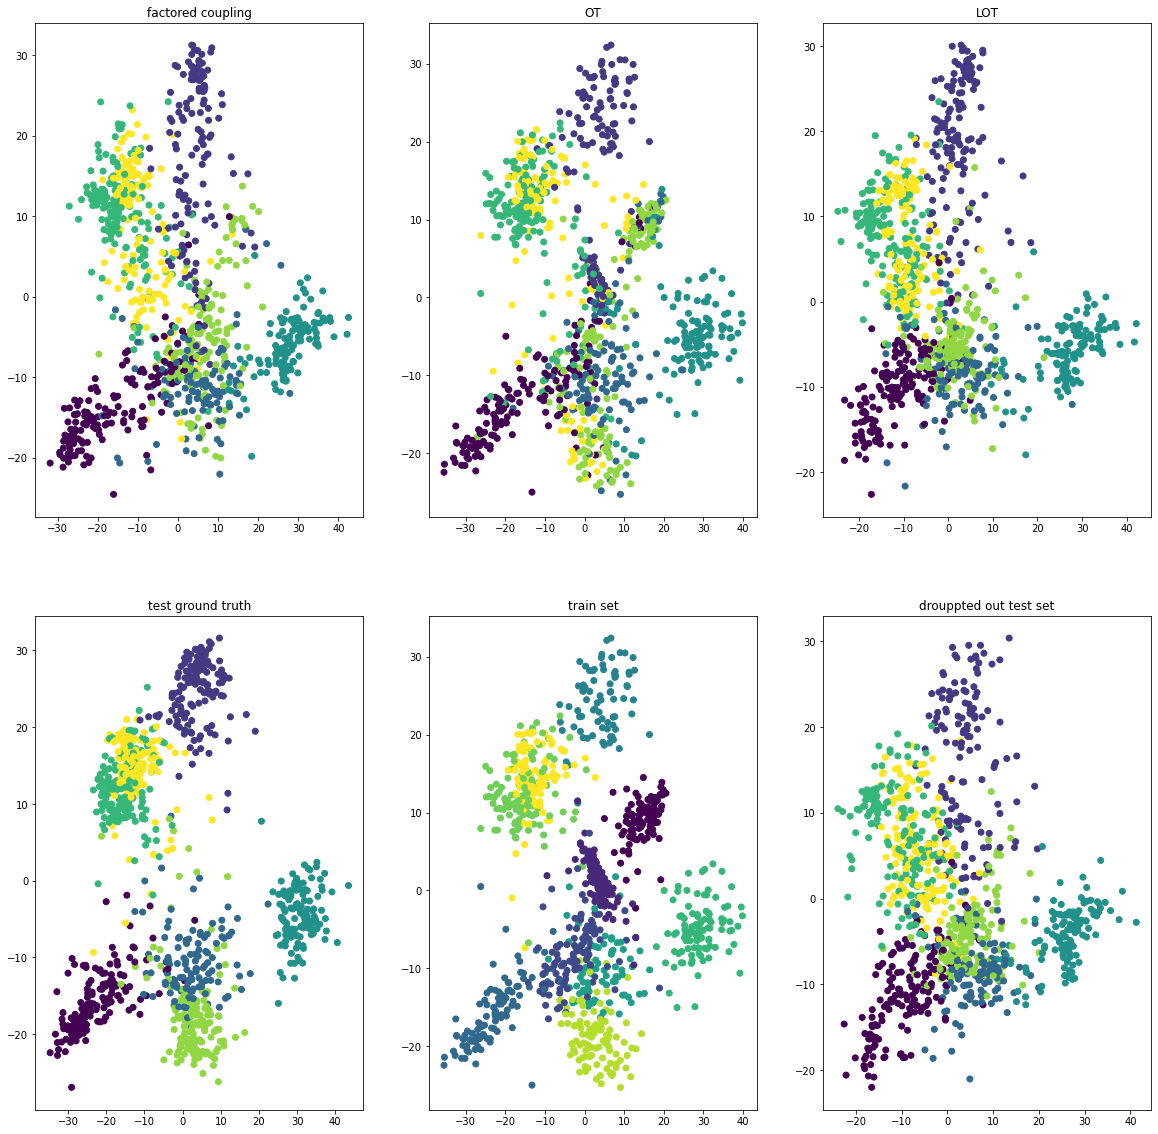

In [17]:
# transport estimation in the paper of FC
n = features_test_aug.shape[0]
m = features_train.shape[0]
Cx_fc = Px_fc.T.dot(features_test_aug) / (Px_fc.T.dot(np.ones([n,1])) + 10**-20) 
Cy_fc = Py_fc.dot(features_train) / ( Py_fc.dot(np.ones([m,1])) + 10**-20)
transported_features_fc = features_test_aug + np.dot(Px_fc / np.sum(Px_fc,axis = 1).reshape([n,1]),Cy_fc - Cx_fc)

# transport estimation with LOT
Cx_lot = Px.T.dot(features_test_aug) / (Px.T.dot(np.ones([n,1])) + 10**-20) 
Cy_lot = Py.dot(features_train) / ( Py.dot(np.ones([m,1])) + 10**-20)
transported_features_lot = features_test_aug + np.dot(np.dot(Px / np.sum(Px,axis = 1).reshape([n,1]), Pz / np.sum(Pz,axis = 1).reshape([cluster_numx,1])),Cy_lot)- np.dot(Px / np.sum(Px,axis = 1).reshape([n,1]) , Cx_lot)

transported_features = np.dot(P_fc, features_train)*1000
transported_features_ot = np.dot(Pot, features_train)*1000
plt.figure(figsize = (20,20))
plt.subplot(2,3,1)
plt.scatter(*isomap.transform(transported_features_fc).T, c=y_test)
plt.title('factored coupling')
plt.subplot(2,3,2)
plt.scatter(*isomap.transform(transported_features_ot).T, c=y_test)
plt.title('OT')
plt.subplot(2,3,3)
plt.scatter(*isomap.transform(transported_features_lot).T, c=y_test)
plt.title('LOT')
plt.subplot(2,3,4)
plt.scatter(*isomap.transform(features_test).T, c=y_test)
plt.title('test ground truth')
plt.subplot(2,3,5)
plt.scatter(*isomap.transform(features_train).T, c=y_train)
plt.title('train set')
plt.subplot(2,3,6)
plt.scatter(*isomap.transform(features_test_aug).T, c=y_test)
plt.title('drouppted out test set')
plt.show()

In [18]:
# a robust variant of LOT by sharpening inner transport plan

maxPz = np.max(Pz,axis =1)
threshold = 0.8
decay = 0
Pz_robust = Pz.copy()
for i in range(0,cluster_numx):
    for j in range(0,cluster_num):
        if Pz[i,j] < maxPz[i] * threshold:
            Pz_robust[i,j] = Pz[i,j] * decay
Pz_robust = Pz_robust / np.sum(Pz_robust, axis = 1).reshape([cluster_numx,1]) * np.sum(Pz,axis =1).reshape([cluster_numx,1])
np.sum(Px,axis =0) - np.sum(Pz_robust,axis =1)
transported_features_lot_robust = features_test_aug + np.dot(np.dot(Px / np.sum(Px,axis = 1).reshape([n,1]), Pz_robust / np.sum(Pz_robust,axis = 1).reshape([cluster_numx,1])),Cy_lot)- np.dot(Px / np.sum(Px,axis = 1).reshape([n,1]) , Cx_lot)


Accuracy of NN classifier: 0.704
Accuracy after OT: 0.585
Accuracy after FC : 0.704
Accuracy after LOT: 0.803
Accuracy after LOT(robust): 0.806
L2 error of OT: 541.2560986660718
L2 error of FC: 428.40703532029255
L2 error of LOT: 416.58040678231913
L2 error of LOT (robust): 416.95512961583626


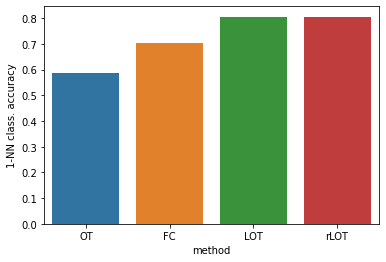

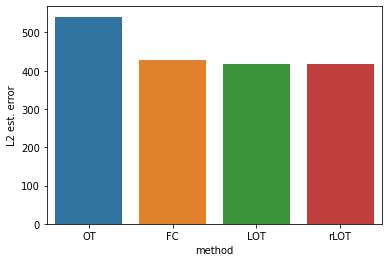

In [19]:
from numpy import linalg as LA
import pandas as pd
import seaborn as sns

# 1-NN classification accuracy 
print('Accuracy of NN classifier:', ogvalue)
_, pred_y = torch.max(torch.tensor(transported_features_ot), 1)
aOT = (pred_y == y_test).sum().item() / y_test.size(0)
print('Accuracy after OT:', aOT)
_, pred_y = torch.max(torch.tensor(transported_features_fc), 1)
aFC = (pred_y == y_test).sum().item() / y_test.size(0)
print('Accuracy after FC :', aFC)
_, pred_y = torch.max(torch.tensor(transported_features_lot), 1)
aLOT = (pred_y == y_test).sum().item() / y_test.size(0)
print('Accuracy after LOT:', aLOT)
_, pred_y = torch.max(torch.tensor(transported_features_lot_robust), 1)
aLOTr = (pred_y == y_test).sum().item() / y_test.size(0)
print('Accuracy after LOT(robust):', aLOTr)

# L2 estimation error
eOT = (LA.norm(transported_features_ot - features_test))
eFC = (LA.norm(transported_features_fc - features_test))
eLOT = (LA.norm(transported_features_lot - features_test))
eLOTr = (LA.norm(transported_features_lot_robust - features_test))

print('L2 error of OT:', eOT)
print('L2 error of FC:', eFC)
print('L2 error of LOT:', eLOT)
print('L2 error of LOT (robust):', eLOTr)

datac = pd.DataFrame({'method':['OT','FC','LOT','rLOT'], '1-NN class. accuracy': [aOT,aFC,aLOT,aLOTr]})
ax = sns.barplot(x = 'method', y = '1-NN class. accuracy', data = datac)
datae = pd.DataFrame({'method':['OT','FC','LOT','rLOT'], 'L2 est. error': [eOT,eFC,eLOT,eLOTr]})
plt.show()
ax = sns.barplot(x = 'method', y = 'L2 est. error', data = datae)
plt.show()